In [2]:
pip install networkx

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.6 MB 953 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [33]:
SPLIT_MODE = "random"
USE_CLASS_WEIGHT = True           
USE_SMOTE = False              
USE_SVD_BASE = True
USE_THRESHOLD_TUNING = True
import hashlib, warnings
import numpy as np
import pandas as pd
import scipy.sparse as sp

from collections import Counter
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    accuracy_score, classification_report, precision_recall_curve , confusion_matrix 
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")
np.random.seed(42)

In [34]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 

In [35]:
SMOTE = None
if USE_SMOTE:
    try:
        from imblearn.over_sampling import SMOTE as _SMOTE
        SMOTE = _SMOTE
    except Exception as e:
        print(" imbalanced-learn/SMOTE not found; skipping SMOTE.", e)
        SMOTE = None

In [36]:
def stable_bucket(s: str, dim: int) -> int:
    return int(hashlib.md5(s.encode("utf-8")).hexdigest(), 16) % dim

def report_split(y_tr, y_te, tag=""):
    c_tr, c_te = Counter(y_tr), Counter(y_te)
    print(f"{tag} Split → Train: {len(y_tr)} (pos={c_tr.get(1,0)}, neg={c_tr.get(0,0)}) | "
          f"Test: {len(y_te)} (pos={c_te.get(1,0)}, neg={c_te.get(0,0)})")

In [37]:
df = pd.read_csv("/Users/tarasetareh/Downloads/ci/full.csv")
df.columns = [c.strip() for c in df.columns]
required_cols = ["SMILES", "Protein", "Y"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"The required columns are not present: {missing}")

df = df.dropna(subset=required_cols).reset_index(drop=True)
df["Y"] = df["Y"].astype(int)

print("Data shape:", df.shape)
print("Class balance:\n", df["Y"].value_counts())

Data shape: (49199, 5)
Class balance:
 Y
0    28525
1    20674
Name: count, dtype: int64


In [38]:
def smiles_to_morgan_fp(smiles: str, nbits=2048, radius=2):
    arr = np.zeros(nbits, dtype=np.int8)
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return arr
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits)
        DataStructs.ConvertToNumpyArray(fp, arr)
    except Exception:
        pass
    return arr

SMI_CHARS = set(list("#%()+-./0123456789=@ABCFHIKLMNOPRSTVXZ[]\\abcegilnoprstu"))

def smiles_hash_features(s: str, ks=(2, 3), dim=4096):
    v = np.zeros(dim, dtype=np.float32)
    s = ''.join([c for c in str(s) if c in SMI_CHARS])
    for k in ks:
        if len(s) < k: 
            continue
        for i in range(len(s)-k+1):
            ngram = s[i:i+k]
            h = stable_bucket(ngram, dim)
            v[h] += 1.0
    if v.sum() > 0:
        v /= v.sum()
    return v
drug_X = sp.csr_matrix(np.vstack([smiles_hash_features(s) for s in df["SMILES"]]))
print("Drug features (SMILES n-gram hash) shape:", drug_X.shape)


Drug features (SMILES n-gram hash) shape: (49199, 4096)


In [39]:
AA = list("ACDEFGHIKLMNPQRSTVWY")
aa_index = {a:i for i,a in enumerate(AA)}

def aa_composition(seq: str):
    cnt = np.zeros(len(AA), dtype=float)
    for ch in str(seq).upper():
        if ch in aa_index:
            cnt[aa_index[ch]] += 1.0
    tot = cnt.sum()
    if tot > 0:
        cnt /= tot
    return cnt

def kmer_hash_features(seq: str, k=3, dim=4096):
    v = np.zeros(dim, dtype=np.float32)
    s = ''.join([c for c in str(seq).upper() if c in aa_index])
    if len(s) < k: 
        return v
    for i in range(len(s)-k+1):
        kmer = s[i:i+k]
        h = stable_bucket(kmer, dim)
        v[h] += 1.0
    if v.sum() > 0:
        v /= v.sum()
    return v

prot_comp = sp.csr_matrix(np.vstack([aa_composition(s) for s in df["Protein"]]))          
prot_kmer = sp.csr_matrix(np.vstack([kmer_hash_features(s) for s in df["Protein"]]))     
prot_X = sp.hstack([prot_comp, prot_kmer], format="csr")
print("Protein features shape:", prot_X.shape)

Protein features shape: (49199, 4116)


In [40]:
X_base = sp.hstack([drug_X, prot_X], format="csr")
y = df["Y"].values
print("Baseline X shape:", X_base.shape)

Baseline X shape: (49199, 8212)


In [41]:
idx_all = np.arange(len(df))

if SPLIT_MODE == "random":
    tr_idx, te_idx = train_test_split(
        idx_all, test_size=0.2, stratify=y, random_state=42
    )
    print("Split: stratified random")
elif SPLIT_MODE == "cold_drug":
    if "drug_cluster" not in df.columns:
        raise ValueError("The 'drug_cluster' column is required for cold_drug.")
    groups = df["drug_cluster"].values
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, te_idx = next(gss.split(idx_all, groups=groups))
    print("Split: cold_drug (by drug_cluster)")
elif SPLIT_MODE == "cold_target":
    if "target_cluster" not in df.columns:
        raise ValueError("The 'target_cluster' column is required for cold_target.")
    groups = df["target_cluster"].values
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, te_idx = next(gss.split(idx_all, groups=groups))
    print("Split: cold_target (by target_cluster)")
else:
    raise ValueError("SPLIT_MODE is not valid")

X_tr_base, X_te_base = X_base[tr_idx], X_base[te_idx]
y_tr, y_te = y[tr_idx], y[te_idx]
df_train = df.iloc[tr_idx].reset_index(drop=True)
df_test  = df.iloc[te_idx].reset_index(drop=True)

report_split(y_tr, y_te)

Split: stratified random
 Split → Train: 39359 (pos=16539, neg=22820) | Test: 9840 (pos=4135, neg=5705)


In [42]:
if USE_SMOTE and (SMOTE is not None):
    print("Applying SMOTE on training set ...")
    sm = SMOTE(random_state=42)
    X_tr_base, y_tr = sm.fit_resample(X_tr_base.toarray(), y_tr)
else:
    pass

In [43]:
if USE_SVD_BASE:
    print(f"Baseline TruncatedSVD → {300} components")
    svd_base = TruncatedSVD(n_components=300, random_state=42)
    X_tr_red = svd_base.fit_transform(X_tr_base)
    X_te_red = svd_base.transform(X_te_base)

    sc_base = StandardScaler()
    X_tr_red = sc_base.fit_transform(X_tr_red)
    X_te_red = sc_base.transform(X_te_red)

    Xtr_for_lr = X_tr_red; Xte_for_lr = X_te_red
    Xtr_for_rf = X_tr_red; Xte_for_rf = X_te_red
    Xtr_for_mlp= X_tr_red; Xte_for_mlp= X_te_red
else:
    Xtr_for_lr = X_tr_base
    Xte_for_lr = X_te_base
    Xtr_for_rf = X_tr_base.toarray()
    Xte_for_rf = X_te_base.toarray()
    Xtr_for_mlp = X_tr_base.toarray()
    Xte_for_mlp = X_te_base.toarray()

Baseline TruncatedSVD → 300 components


Explained variance (cumulative) @ 300 comps = 0.922


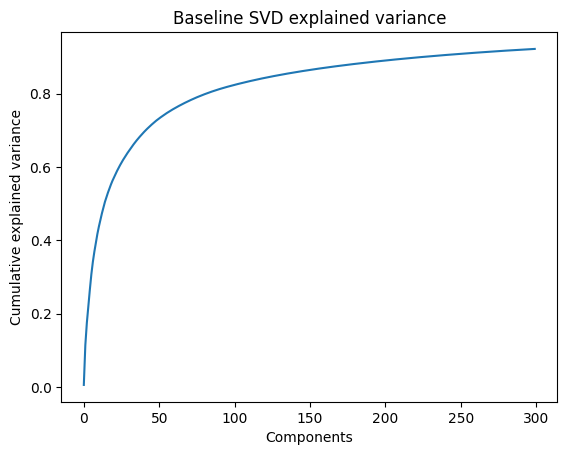

In [44]:
import numpy as np
import matplotlib.pyplot as plt

evr = svd_base.explained_variance_ratio_
cum = np.cumsum(evr)
print(f"Explained variance (cumulative) @ {300} comps = {cum[-1]:.3f}")

plt.figure()
plt.plot(cum)
plt.xlabel("Components")
plt.ylabel("Cumulative explained variance")
plt.title("Baseline SVD explained variance")
plt.show()

In [45]:
import networkx as nx # type: ignore

def build_bipartite_graph_from_pos(df_pos):
    G = nx.Graph()
    for _, r in df_pos.iterrows():
        d = f"drug_{r['SMILES']}"
        p = f"prot_{r['Protein']}"
        G.add_node(d, bipartite='drug')
        G.add_node(p, bipartite='protein')
        G.add_edge(d, p)
    return G

G = build_bipartite_graph_from_pos(df_train[df_train["Y"]==1].copy())
print("NetworkX graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

NetworkX graph: 13920 nodes, 16539 edges


In [22]:
pip install node2vec

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 24.0 MB 93 kB/s eta 0:00:011     |██████████████▊                 | 11.1 MB 135 kB/s eta 0:01:36
     |████████████████████████████████| 78 kB 120 kB/s eta 0:00:01
     |████████████████████████████████| 61 kB 155 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [46]:
from node2vec import Node2Vec

n2v = Node2Vec(
    G, dimensions=128, walk_length=80, num_walks=10,
    workers=4, p=1, q=1, seed=42
)
model = n2v.fit(window=10, min_count=1, batch_words=4)
node2vec_emb = {str(n): model.wv[str(n)] for n in G.nodes()}

def pair_embed_features_n2v(df_pairs):
    D, P = [], []
    for _, r in df_pairs.iterrows():
        dkey = f"drug_{r['SMILES']}"
        pkey = f"prot_{r['Protein']}"
        dv = node2vec_emb.get(dkey, np.zeros(128))
        pv = node2vec_emb.get(pkey, np.zeros(128))
        D.append(dv); P.append(pv)
    D = np.vstack(D); P = np.vstack(P)
    return np.hstack([D, P, np.abs(D-P), D*P]).astype(np.float32)

Xtr_g_n2v = pair_embed_features_n2v(df_train)
Xte_g_n2v = pair_embed_features_n2v(df_test)



Generating walks (CPU: 2): 100%|██████████| 3/3 [00:24<00:00,  8.06s/it]


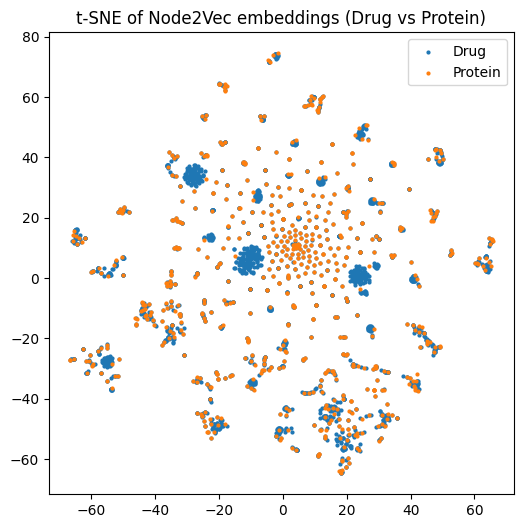

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

nodes = list(node2vec_emb.keys())
sample = nodes[:3000] if len(nodes) > 3000 else nodes

X_vis = np.vstack([node2vec_emb[n] for n in sample])
labels = np.array([1 if n.startswith("drug_") else 0 for n in sample])

ts = TSNE(n_components=2, init="random", random_state=42, perplexity=30)
XY = ts.fit_transform(X_vis)

plt.figure(figsize=(6,6))
plt.scatter(XY[labels==1,0], XY[labels==1,1], s=4, c="tab:blue", label="Drug")
plt.scatter(XY[labels==0,0], XY[labels==0,1], s=4, c="tab:orange", label="Protein")
plt.legend()
plt.title("t-SNE of Node2Vec embeddings (Drug vs Protein)")
plt.show()


In [47]:
from scipy import sparse
from scipy.sparse.linalg import svds

drugs = sorted([n for n,attr in G.nodes(data=True) if attr.get('bipartite')=='drug'])
prots = sorted([n for n,attr in G.nodes(data=True) if attr.get('bipartite')=='protein'])
d2i = {d:i for i,d in enumerate(drugs)}
p2i = {p:i for i,p in enumerate(prots)}

B = sparse.lil_matrix((len(drugs), len(prots)), dtype=np.float32)
for u, v in G.edges():
    if u.startswith('drug_'):
        di, pj = d2i[u], p2i[v]
    else:
        di, pj = d2i[v], p2i[u]
    B[di, pj] = 1.0
B = B.tocsr()

k = max(10, min(128, min(B.shape)-2)) 
u, s, vt = svds(B, k=k, return_singular_vectors=True)
order = np.argsort(s)[::-1]
u, s, vt = u[:, order], s[order], vt[order, :]

S_half = np.sqrt(s)
drug_emb = u * S_half          
prot_emb = (vt.T) * S_half         

def pair_embed_features(df_pairs):
    D, P = [], []
    for _, r in df_pairs.iterrows():
        dkey = f"drug_{r['SMILES']}"
        pkey = f"prot_{r['Protein']}"
        dv = drug_emb[d2i[dkey]] if dkey in d2i else np.zeros(k, dtype=np.float32)
        pv = prot_emb[p2i[pkey]] if pkey in p2i else np.zeros(k, dtype=np.float32)
        D.append(dv); P.append(pv)
    D = np.vstack(D); P = np.vstack(P)
    return np.hstack([D, P, np.abs(D-P), D*P]).astype(np.float32)

Xtr_g = pair_embed_features(df_train)  
Xte_g = pair_embed_features(df_test)
print("Graph pair-features:", Xtr_g.shape, Xte_g.shape)

svd_g = TruncatedSVD(n_components=min(128, Xtr_g.shape[1]-1), random_state=42)
Xtr_g_red = svd_g.fit_transform(Xtr_g)
Xte_g_red = svd_g.transform(Xte_g)

sc_g = StandardScaler()
Xtr_g_red = sc_g.fit_transform(Xtr_g_red)
Xte_g_red = sc_g.transform(Xte_g_red)
print("Reduced graph pair-features:", Xtr_g_red.shape, Xte_g_red.shape)


Graph pair-features: (39359, 512) (9840, 512)
Reduced graph pair-features: (39359, 128) (9840, 128)


In [48]:
def find_best_threshold(y_true, scores):
    pr, rc, th = precision_recall_curve(y_true, scores)
    f1s = []
    for p, r in zip(pr[:-1], rc[:-1]):
        if (p+r) == 0:
            f1s.append(0.0)
        else:
            f1s.append(2*p*r/(p+r))
    best = np.argmax(f1s)
    return th[best] if len(th) > 0 else 0.5

def eval_model(clf, X_tr, y_tr, X_te, y_te, name, tune_threshold=USE_THRESHOLD_TUNING):
    clf.fit(X_tr, y_tr)
    if hasattr(clf, "predict_proba"):
        proba_tr = clf.predict_proba(X_tr)[:,1]
        proba_te = clf.predict_proba(X_te)[:,1]
    else:
        proba_tr = clf.decision_function(X_tr)
        proba_te = clf.decision_function(X_te)

    thr = 0.5
    if tune_threshold:
        thr = find_best_threshold(y_tr, proba_tr)

    preds_te = (proba_te >= thr).astype(int)
    metrics = {
        "model": name,
        "thr": float(thr),
        "ROC_AUC": float(roc_auc_score(y_te, proba_te)),
        "PR_AUC":  float(average_precision_score(y_te, proba_te)),
        "F1":      float(f1_score(y_te, preds_te)),
        "ACC":     float(accuracy_score(y_te, preds_te)),
    }
    print(f"\n{name} {metrics}")
    print(classification_report(y_te, preds_te, digits=3))
    print("Confusion Matrix @best_thr:\n", confusion_matrix(y_te, preds_te))
    print("F1 @best_thr:", f1_score(y_te, preds_te))
    return metrics


results = []

lr_base = LogisticRegression(
    max_iter=5000, solver="saga",
    class_weight=("balanced" if USE_CLASS_WEIGHT else None),
    n_jobs=-1, random_state=42
)
rf_base = RandomForestClassifier(
    n_estimators=300, max_depth=None, n_jobs=-1, random_state=42,
    class_weight=("balanced" if USE_CLASS_WEIGHT else None)
)
mlp_base = MLPClassifier(
    hidden_layer_sizes=(512,256), activation="relu",
    batch_size=512, max_iter=100, random_state=42
)

results.append(eval_model(lr_base,  Xtr_for_lr, y_tr, Xte_for_lr, y_te, "LogReg(Baseline)"))
results.append(eval_model(rf_base,  Xtr_for_rf, y_tr, Xte_for_rf, y_te, "RandomForest(Baseline)"))
results.append(eval_model(mlp_base, Xtr_for_mlp, y_tr, Xte_for_mlp, y_te, "MLP(Baseline)"))


lr_g = LogisticRegression(
    max_iter=5000, solver="saga",
    class_weight=("balanced" if USE_CLASS_WEIGHT else None),
    n_jobs=-1, random_state=42
)
rf_g = RandomForestClassifier(
    n_estimators=300, max_depth=None, n_jobs=-1, random_state=42,
    class_weight=("balanced" if USE_CLASS_WEIGHT else None)
)
mlp_g = MLPClassifier(
    hidden_layer_sizes=(512,256), activation="relu",
    batch_size=512, max_iter=100, random_state=42
)

results.append(eval_model(lr_g,  Xtr_g_red, y_tr, Xte_g_red, y_te, "LogReg(GraphEmb)"))
results.append(eval_model(rf_g,  Xtr_g_red, y_tr, Xte_g_red, y_te, "RandomForest(GraphEmb)"))
results.append(eval_model(mlp_g, Xtr_g_red, y_tr, Xte_g_red, y_te, "MLP(GraphEmb)"))


Xtr_fused = np.hstack([Xtr_for_lr, Xtr_g_red])
Xte_fused = np.hstack([Xte_for_lr, Xte_g_red])

lr_f = LogisticRegression(
    max_iter=5000, solver="saga",
    class_weight=("balanced" if USE_CLASS_WEIGHT else None),
    n_jobs=-1, random_state=42
)
rf_f = RandomForestClassifier(
    n_estimators=350, max_depth=None, n_jobs=-1, random_state=42,
    class_weight=("balanced" if USE_CLASS_WEIGHT else None)
)
mlp_f = MLPClassifier(
    hidden_layer_sizes=(512,256), activation="relu",
    batch_size=512, max_iter=150, random_state=42
)

results.append(eval_model(lr_f,  Xtr_fused, y_tr, Xte_fused, y_te, "LogReg(Fused)"))
results.append(eval_model(rf_f,  Xtr_fused, y_tr, Xte_fused, y_te, "RandomForest(Fused)"))
results.append(eval_model(mlp_f, Xtr_fused, y_tr, Xte_fused, y_te, "MLP(Fused)"))
results.append(eval_model(lr_g,  Xtr_g_n2v, y_tr, Xte_g_n2v, y_te, "LogReg(Node2Vec)"))
results.append(eval_model(rf_g,  Xtr_g_n2v, y_tr, Xte_g_n2v, y_te, "RandomForest(Node2Vec)"))
results.append(eval_model(mlp_g, Xtr_g_n2v, y_tr, Xte_g_n2v, y_te, "MLP(Node2Vec)"))




LogReg(Baseline) {'model': 'LogReg(Baseline)', 'thr': 0.39191807229986947, 'ROC_AUC': 0.8177692619914859, 'PR_AUC': 0.7675364681869399, 'F1': 0.7083005507474429, 'ACC': 0.6985772357723578}
              precision    recall  f1-score   support

           0      0.860     0.574     0.688      5705
           1      0.597     0.871     0.708      4135

    accuracy                          0.699      9840
   macro avg      0.728     0.722     0.698      9840
weighted avg      0.749     0.699     0.697      9840

Confusion Matrix @best_thr:
 [[3273 2432]
 [ 534 3601]]
F1 @best_thr: 0.7083005507474429

RandomForest(Baseline) {'model': 'RandomForest(Baseline)', 'thr': 0.5207074646625746, 'ROC_AUC': 0.947681884513362, 'PR_AUC': 0.9340576999123108, 'F1': 0.8057174576741605, 'ACC': 0.8577235772357723}
              precision    recall  f1-score   support

           0      0.818     0.971     0.888      5705
           1      0.945     0.702     0.806      4135

    accuracy                  

In [49]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(["PR_AUC","ROC_AUC"], ascending=False).reset_index(drop=True)
print("\n Summary (sorted by PR_AUC, ROC_AUC) \n", df_results)
def map_repr(name: str) -> str:
    if "Fused" in name: return "Fused"
    if "Node2Vec" in name: return "Node2Vec"
    if "GraphEmb" in name or "GraphEmb" in name or "Graph" in name: return "Graph-SVD"
    return "Baseline"

df_results["repr"] = df_results["model"].apply(map_repr)
abl = (df_results.groupby("repr")[["PR_AUC","ROC_AUC"]]
       .max().sort_values("PR_AUC", ascending=False))
print("\n Ablation (best per representation) \n", abl)
DO_CV = True
if DO_CV:
    X_full = np.vstack([Xtr_fused, Xte_fused])
    y_full = np.concatenate([y_tr, y_te]).astype(int)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs, pr_aucs = [], []
    for tr_i, te_i in skf.split(X_full, y_full):
        clf = LogisticRegression(
            max_iter=5000, solver="saga",
            class_weight=("balanced" if USE_CLASS_WEIGHT else None),
            n_jobs=-1, random_state=42
        )
        clf.fit(X_full[tr_i], y_full[tr_i])
        p = clf.predict_proba(X_full[te_i])[:,1]
        aucs.append(roc_auc_score(y_full[te_i], p))
        pr_aucs.append(average_precision_score(y_full[te_i], p))
    print(f"CV (LogReg-Fused) | ROC-AUC: {np.mean(aucs):.3f}±{np.std(aucs):.3f} | "
          f"PR-AUC: {np.mean(pr_aucs):.3f}±{np.std(pr_aucs):.3f}")



 Summary (sorted by PR_AUC, ROC_AUC) 
                      model       thr   ROC_AUC    PR_AUC        F1       ACC
0               MLP(Fused)  0.519537  0.952438  0.938945  0.874663  0.895935
1            MLP(Baseline)  0.404848  0.951170  0.934970  0.876410  0.896443
2   RandomForest(Baseline)  0.520707  0.947682  0.934058  0.805717  0.857724
3            LogReg(Fused)  0.425763  0.855348  0.818596  0.732818  0.747154
4            MLP(GraphEmb)  0.362584  0.827935  0.813283  0.704687  0.763720
5      RandomForest(Fused)  0.588571  0.815799  0.798950  0.472701  0.704573
6         LogReg(GraphEmb)  0.483763  0.786571  0.776600  0.684810  0.761077
7         LogReg(Baseline)  0.391918  0.817769  0.767536  0.708301  0.698577
8   RandomForest(GraphEmb)  0.576667  0.728543  0.701247  0.378462  0.671545
9         LogReg(Node2Vec)  0.466091  0.641302  0.613297  0.321076  0.651016
10  RandomForest(Node2Vec)  0.676667  0.582232  0.603197  0.165414  0.616463
11           MLP(Node2Vec)  0.321346

Detected variables:
  X_tr_base: sparse (39359, 8212)
  X_tr_red: dense (39359, 300)
  X_tr_graph: None
  X_te_base: sparse (9840, 8212)
  X_te_red: dense (9840, 300)
  X_te_graph: None
  y_tr: 39359
  y_te: 9840
Fusion shapes: (39359, 300) (9840, 300)
Blocks included: [('BASE_RED', 300)]
Training LogisticRegression on Fusion...
Fusion(LogReg) | Train ROC-AUC: 0.824 | PR-AUC: 0.774
Fusion(LogReg) |  Test ROC-AUC: 0.818 | PR-AUC: 0.770
Computing permutation importance on a test subsample: (4000, 300)


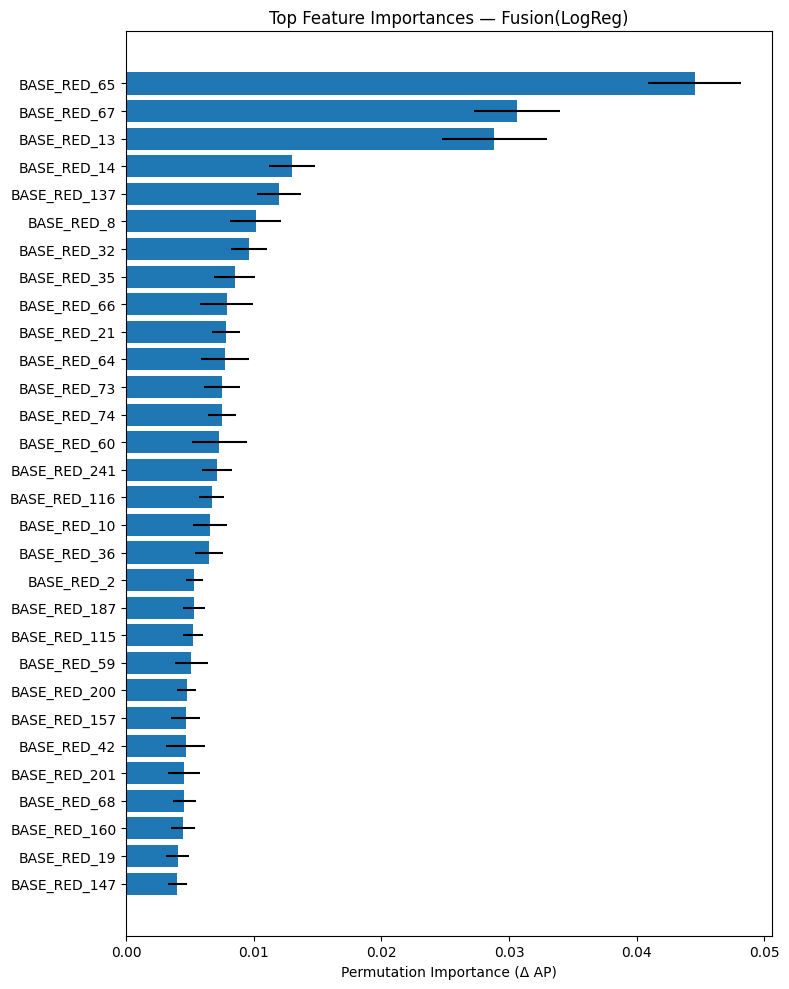


Interpretation tip: PREFIX shows the block:
  - BASE/BASE_RED: baseline features (e.g., Morgan FP + protein features after reduction)
  - GRAPH: graph/pair features (random walk/node2vec/structure-based, reduced if *_RED)
Higher ΔAP means the feature contributes more to ranking positives higher in PR space.


In [52]:
import numpy as np
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def _varnames_like(substrs):
    names = []
    for k in list(globals().keys()):
        try:
            ks = k.lower()
        except Exception:
            continue
        ok = True
        for s in substrs:
            if s not in ks:
                ok = False
                break
        if ok:
            names.append(k)
    return sorted(names)

def pick_matrix(candidates, must_be_train=True):
    for substrs, friendly in candidates:
        matches = _varnames_like(substrs)
        if matches:
            chosen = sorted(matches, key=len)[0]
            return chosen, globals()[chosen]
    return None, None

def safe_hstack(blocks):
    blocks = [b for b in blocks if b is not None]
    if not blocks:
        return None
    is_sparse = any(sp.issparse(b) for b in blocks)
    if is_sparse:
        blocks = [b if sp.issparse(b) else sp.csr_matrix(b) for b in blocks]
        return sp.hstack(blocks).tocsr()
    else:
        return np.hstack(blocks)

def describe(name, X):
    if X is None: 
        return f"{name}: None"
    shape = X.shape
    typ = "sparse" if sp.issparse(X) else "dense"
    return f"{name}: {typ} {shape}"

Xtr_base_name, X_tr_base = pick_matrix([ (["x","tr","base"], "X_tr_base") ])
Xtr_red_name,  X_tr_red  = pick_matrix([ (["x","tr","red"], "X_tr_red") ])
Xtr_graph_name, X_tr_graph = pick_matrix([ (["x","tr","graph","red"], "X_tr_graph_red"),
                                           (["x","tr","graph"], "X_tr_graph"),
                                           (["x","tr","pair","red"], "X_tr_pair_red"),
                                           (["x","tr","pair"], "X_tr_pair") ])

Xte_base_name, X_te_base = pick_matrix([ (["x","te","base"], "X_te_base") ], must_be_train=False)
Xte_red_name,  X_te_red  = pick_matrix([ (["x","te","red"], "X_te_red") ], must_be_train=False)
Xte_graph_name, X_te_graph = pick_matrix([ (["x","te","graph","red"], "X_te_graph_red"),
                                           (["x","te","graph"], "X_te_graph"),
                                           (["x","te","pair","red"], "X_te_pair_red"),
                                           (["x","te","pair"], "X_te_pair") ], must_be_train=False)

y_tr_name, y_tr = pick_matrix([ (["y","tr"], "y_tr") ])
y_te_name, y_te = pick_matrix([ (["y","te"], "y_te") ], must_be_train=False)

print("Detected variables:")
print(" ", describe(Xtr_base_name or "X_tr_base", X_tr_base))
print(" ", describe(Xtr_red_name  or "X_tr_red",  X_tr_red))
print(" ", describe(Xtr_graph_name or "X_tr_graph", X_tr_graph))
print(" ", describe(Xte_base_name or "X_te_base", X_te_base))
print(" ", describe(Xte_red_name  or "X_te_red",  X_te_red))
print(" ", describe(Xte_graph_name or "X_te_graph", X_te_graph))
print(" ", f"y_tr: {None if y_tr is None else len(y_tr)}")
print(" ", f"y_te: {None if y_te is None else len(y_te)}")
train_blocks = []
test_blocks  = []
block_names  = []

if X_tr_red is not None and X_te_red is not None:
    train_blocks.append(X_tr_red); test_blocks.append(X_te_red); block_names.append(("BASE_RED", X_tr_red.shape[1]))
elif X_tr_base is not None and X_te_base is not None:
    train_blocks.append(X_tr_base); test_blocks.append(X_te_base); block_names.append(("BASE", X_tr_base.shape[1]))

if X_tr_graph is not None and X_te_graph is not None:
    train_blocks.append(X_tr_graph); test_blocks.append(X_te_graph);
    block_names.append(("GRAPH", X_tr_graph.shape[1]))

if not train_blocks or not test_blocks:
    raise RuntimeError(
        "Could not assemble fusion features. Ensure your notebook defines any of these pairs:\n"
        "- (X_tr_red, X_te_red) or (X_tr_base, X_te_base)\n"
        "- optionally add (X_tr_graph[_red], X_te_graph[_red]) for graph features\n"
        "Also ensure (y_tr, y_te) are available."
    )

X_tr_fusion = safe_hstack(train_blocks)
X_te_fusion = safe_hstack(test_blocks)

print("Fusion shapes:", X_tr_fusion.shape, X_te_fusion.shape)
print("Blocks included:", block_names)
lr = LogisticRegression(
    penalty="l2",
    solver="saga",
    C=1.0,
    max_iter=2000,
    n_jobs=-1,
    random_state=42
)

print("Training LogisticRegression on Fusion...")
lr.fit(X_tr_fusion, y_tr)
p_tr = lr.predict_proba(X_tr_fusion)[:,1]
p_te = lr.predict_proba(X_te_fusion)[:,1]

roc_tr = roc_auc_score(y_tr, p_tr)
pr_tr  = average_precision_score(y_tr, p_tr)
roc_te = roc_auc_score(y_te, p_te)
pr_te  = average_precision_score(y_te, p_te)

print(f"Fusion(LogReg) | Train ROC-AUC: {roc_tr:.3f} | PR-AUC: {pr_tr:.3f}")
print(f"Fusion(LogReg) |  Test ROC-AUC: {roc_te:.3f} | PR-AUC: {pr_te:.3f}")

n_perm_samples = min(4000, X_te_fusion.shape[0])
rng = np.random.RandomState(42)
idx = rng.choice(X_te_fusion.shape[0], size=n_perm_samples, replace=False)
X_te_sub = X_te_fusion[idx]
y_te_sub = np.asarray(y_te)[idx]

print("Computing permutation importance on a test subsample:", X_te_sub.shape)
pi = permutation_importance(lr, X_te_sub, y_te_sub, n_repeats=10, random_state=42, n_jobs=-1, scoring="average_precision")

importances = pi.importances_mean
stds = pi.importances_std
feat_names = []
offset = 0
for name, width in block_names:
    for j in range(width):
        feat_names.append(f"{name}_{j+1}")
    offset += width

k = min(30, len(importances))
order = np.argsort(importances)[::-1][:k]
top_names = [feat_names[i] for i in order]
top_vals  = importances[order]
top_std   = stds[order]

plt.figure(figsize=(8, max(5, int(k*0.35))))
ypos = np.arange(k)
plt.barh(ypos, top_vals, xerr=top_std)
plt.yticks(ypos, top_names)
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance (Δ AP)")
plt.title("Top Feature Importances — Fusion(LogReg)")
plt.tight_layout()
plt.show()

print("\nInterpretation tip: PREFIX shows the block:\n"
      "  - BASE/BASE_RED: baseline features (e.g., Morgan FP + protein features after reduction)\n"
      "  - GRAPH: graph/pair features (random walk/node2vec/structure-based, reduced if *_RED)\n"
      "Higher ΔAP means the feature contributes more to ranking positives higher in PR space.")
